# CAI assets choosing 

## Setting

In [1]:
import pandas as pd
import numpy as np
import requests
import json

In [2]:
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()

In [3]:
from defillama import DefiLlama
llama = DefiLlama()

In [4]:
import plotly.express as px
import plotly.graph_objects as go

/home/evgeniy/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

## Data retrieving and filtering

### Token inclusion criteria

1. **Project and token characteristics** 
    1. The project must have a listing on Defi Llama
    1. The project’s token should have been listed on CoinGecko with pricing data at least 1 year prior to the date of inclusion in the index. 
    1. The project should have a token that is native to Ethereum L1 or L2. This excludes wrapped variants, where the underlying tokens are locked on an alt-L1.
    1. The project should be a going concern, with a dedicated team actively building, supporting and maintaining the project. 
    1. No rebasing or deflationary tokens.
    1. The project must be widely considered to be building a useful protocol or product. Projects that have ponzi characteristics at the core of their offering will not be considered.
    1. Synthetic tokens which derive their value from external price feeds are not permissible. 
    1. The project’s token must not have the ability to pause token transfers.
    1. The project’s protocol or product must have significant usage.
    
    
1. **Token Supply requirements**
    1. The project's token must have a circulating supply greater than 30% of the max supply. In cases where a token does not have a max supply, the minting mechanics would need to be assessed.
    1. The token must not have locking, minting or other patterns that would significantly disadvantage passive holders.


1. **Liquidity Requirements**
    1. The token must be listed on a supported exchange.
    1. The token should have in aggregate at least $5mm of onchain liquidity across Uniswap v2, Uniswap v3, Sushiswap, Balancer v1, Balancer v2, Bancor v2 and Bancor v3.
    1. The token must have shown consistent DeFi liquidity on Ethereum.


1. **Security Requirements**
    1. The project must have been audited by smart contract security professionals with the audit report(s) publicly available. Alternatively, the protocol must have been operating long enough to create a consensus about its safety in the decentralised finance community.

### Tokens list

In [6]:
def normalize_symb(symb):
    return ''.join(c for c in symb if c.isalnum()).upper()

#### CoinGecko

##### Tokens addresses

In [7]:
coins_list = cg.get_coins_list(include_platform=True)
coins = {}
for coin in coins_list:
    if 'avalanche' in coin['platforms']:
        coin['addr'] = coin['platforms']['avalanche']
        coin['symbol'] = normalize_symb(coin['symbol'])
        coins[coin['id']] = coin

In [8]:
coins['avalanche-2']

{'id': 'avalanche-2',
 'symbol': 'AVAX',
 'name': 'Avalanche',
 'platforms': {'avalanche': 'FvwEAhmxKfeiG8SnEvq42hc6whRyY3EFYAvebMqDNDGCgxN5Z',
  'defi-kingdoms-blockchain': '0xb57b60debdb0b8172bb6316a9164bd3c695f133a',
  'milkomeda-cardano': '0x65e66a61d0a8f1e686c2d6083ad611a10d84d97a',
  'polygon-pos': '0x2c89bbc92bd86f8075d1decc58c7f4e0107f286b',
  'moonbeam': '0x4792c1ecb969b036eb51330c63bd27899a13d84e',
  'harmony-shard-0': 'one14tvk6p8spdcch8k58cuahrnnmesua79he3xzld',
  'solana': '7JnHPPJBBKSTJ7iEmsiGSBcPJgbcKw28uCRXtQgimncp',
  'moonriver': '0x14a0243c333a5b238143068dc3a7323ba4c30ecb'},
 'addr': 'FvwEAhmxKfeiG8SnEvq42hc6whRyY3EFYAvebMqDNDGCgxN5Z'}

##### Market data

In [9]:
cat_id = "avalanche-ecosystem"
cg_tokens_data = cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', category=cat_id)
for i in range(2, 20):
    cg_tokens_data.extend(cg.get_coins_markets(vs_currency='USD', order='market_cap_desc', category=cat_id, page=i))
    
cg_tokens_data = pd.DataFrame.from_records(cg_tokens_data)

In [10]:
tokens_market_data = cg_tokens_data.set_index('id')[
    ['name', 'symbol', 'market_cap', 'market_cap_rank', 'current_price', 'total_supply', 'circulating_supply']
]
tokens_market_data['symbol'] = tokens_market_data['symbol'].apply(normalize_symb)

In [11]:
tokens_market_data = tokens_market_data[tokens_market_data['market_cap'] > 0]
tokens_market_data = tokens_market_data.drop_duplicates()

In [12]:
tokens_market_data = tokens_market_data.join(pd.DataFrame.from_dict(coins, orient='index')['addr'])
# tokens_market_data = tokens_market_data[~tokens_market_data['addr'].isna()]

In [13]:
tokens_market_data = tokens_market_data.sort_values('market_cap', ascending=False)
tokens_market_data

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
tether,Tether,USDT,6.590378e+10,3.0,1.001000,6.587632e+10,6.587632e+10,0x9702230a8ea53601f5cd2dc00fdbc13d4df4a8c7
usd-coin,USD Coin,USDC,5.430109e+10,4.0,1.000000,5.427012e+10,5.427012e+10,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e
binancecoin,BNB,BNB,5.226154e+10,5.0,320.090000,1.632770e+08,1.632770e+08,NaN
binance-usd,Binance USD,BUSD,1.791761e+10,7.0,0.999864,1.792014e+10,1.792014e+10,0x19860ccb0a68fd4213ab9d8266f7bbf05a8dde98
dai,Dai,DAI,7.015612e+09,13.0,1.000000,7.011385e+09,7.011385e+09,0xd586e7f844cea2f87f50152665bcbc2c279d8d70
...,...,...,...,...,...,...,...,...
impermax,Impermax,IMX,1.387608e+04,3677.0,0.000280,1.000000e+08,4.962231e+07,0xea6887e4a9cda1b77e70129e5fba830cdb5cddef
nft-soccer-games,NFT Soccer Games,NFSG,1.302633e+04,3683.0,0.171435,2.000000e+05,8.496491e+04,0xf69c2fcd9128d49dfa22348c69177f9380438eb8
hermes,HERMES,HERMES,4.892680e+03,3773.0,1.300000,9.910050e+03,6.055892e+03,0xb15f02f9da8cd1f99e9dd375f21dc96d25ddd82c
sins-finance,Sins Finance,SIN,2.182240e+03,3808.0,0.018468,1.000000e+06,1.181640e+05,0x23ba4272a5c5b5641c751521d57e3413c6703131


### Token's supply check 

In [14]:
sp_passed_index = (tokens_market_data['circulating_supply'] / tokens_market_data['total_supply']) > 0.3
sp_passed = tokens_market_data[sp_passed_index]

### Liquidity check

##### 0x sources 
// 20220801153821

// https://avalanche.api.0x.org/swap/v1/sources

```
{
  "records": [
    "Aave_V2",
    "Curve",
    "Curve_V2",
    "GMX",
    "KyberDMM",
    "MultiHop",
    "Pangolin",
    "Platypus",
    "SushiSwap",
    "Synapse",
    "TraderJoe"
  ]
}
```

In [16]:
api_urls = {
    'trader_joe': "https://api.thegraph.com/subgraphs/name/traderjoe-xyz/exchange",
    'pangolin': "https://api.thegraph.com/subgraphs/name/pangolindex/exchange",
    # 'curve': "",
    # 'SushiSwap': "",
    # 'MultiHop': ""
} 

In [17]:
tokens_ids = list(tokens_market_data['addr'].dropna())

In [18]:
gecko_ids = pd.Series(tokens_market_data.index, index=tokens_market_data['addr'])
gecko_ids = gecko_ids.groupby(gecko_ids.index).first()

In [19]:
def trader_joe_liqs(tokens_ids):
    query = """
        query tokens ($tokens_ids: [ID!]!) {
            tokens (first:1000, where: {id_in: $tokens_ids}){
                id
                symbol
                liquidity
            }
        }
    """
    url = api_urls['trader_joe']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    tokens = response.json()['data']['tokens']
    
    liqs = {}
    for token in tokens:
        liqs[gecko_ids[token['id'].lower()]] = float(token['liquidity'])
        
    return liqs

In [36]:
def pangolin_liqs(token_ids):
    query = """
        query tokens ($tokens_ids: [ID!]!) {
            tokens (first:1000, where: {id_in: $tokens_ids}){
                id
                symbol
                totalLiquidity
            }
        }
    """
    url = api_urls['pangolin']
    
    response = requests.post(url, json={'query': query, 'variables': {'tokens_ids': tokens_ids}})
    tokens = response.json()['data']['tokens']
    
    liqs = {}
    for token in tokens:
        liqs[gecko_ids[token['id'].lower()]] = float(token['totalLiquidity'])
        
    return liqs

In [41]:
query_functions = {
    'trader_joe': trader_joe_liqs,
    'pangolin': pangolin_liqs
}

In [42]:
liqs_dict = {}
for dex, func in query_functions.items():
    liqs_dict[dex] = func(tokens_ids)

In [43]:
liquidities = pd.DataFrame.from_dict(liqs_dict)

In [44]:
liquidities['sum'] = liquidities.sum(axis=1)
liquidities.sort_values('sum', ascending=False)

,trader_joe,pangolin,sum
spore,1.121031e+13,2.393398e+15,2.404609e+15
husky-avax,2.294029e+12,5.111019e+12,7.405048e+12
nucleus-vision,5.754840e-13,7.436180e+08,7.436180e+08
everrise,4.633588e+08,NaN,4.633588e+08
islander,3.431457e+08,2.890911e+07,3.720548e+08
...,...,...,...
0x,1.188172e-01,2.967232e-02,1.484896e-01
compound-governance-token,4.901905e-02,9.814440e-04,5.000049e-02
maker,NaN,4.389969e-02,4.389969e-02
kyber-network-crystal,6.090479e-03,NaN,6.090479e-03


In [45]:
liq_check = (liquidities['sum'] > 5e6).sort_values(ascending=False)
liq_check_passed = liq_check[liq_check]

In [47]:
lq_passed = sp_passed[
    sp_passed.index.isin(liq_check_passed.index)
]

In [48]:
lq_passed

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
tether,Tether,USDT,6.590378e+10,3.0,1.001000e+00,6.587632e+10,6.587632e+10,0x9702230a8ea53601f5cd2dc00fdbc13d4df4a8c7
usd-coin,USD Coin,USDC,5.430109e+10,4.0,1.000000e+00,5.427012e+10,5.427012e+10,0xb97ef9ef8734c71904d8002f8b6bc66dd9c48a6e
spell-token,Spell,SPELL,1.082139e+08,257.0,1.117200e-03,1.960087e+11,9.701820e+10,0xce1bffbd5374dac86a2893119683f4911a2f7814
joe,JOE,JOE,1.053230e+08,264.0,3.451500e-01,4.034177e+08,3.055305e+08,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd
everrise,EverRise,RISE,5.314177e+07,418.0,7.424000e-04,7.161803e+10,7.154609e+10,0xc17c30e98541188614df99239cabd40280810ca3
benqi,BENQI,QI,4.594087e+07,458.0,1.713920e-02,7.200000e+09,2.680260e+09,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5
pendle,Pendle,PENDLE,5.427692e+06,1128.0,5.612900e-02,2.120040e+08,9.695072e+07,0xfb98b335551a418cd0737375a2ea0ded62ea213b
zookeeper,ZooKeeper,ZOO,4.960697e+06,1153.0,2.454409e-02,2.162614e+08,2.022660e+08,0x1b88d7ad51626044ec62ef9803ea264da4442f32
stacktical,DSLA Protocol,DSLA,4.347002e+06,1220.0,8.256200e-04,5.709763e+09,5.266888e+09,0xd7c295e399ca928a3a14b01d760e794f1adf8990
spore,Spore,SPORE,9.009030e+05,2066.0,2.627100e-11,3.427493e+16,3.427493e+16,0x6e7f5c0b9f4432716bdd0a77a3601291b9d9e985


### Non quantative checks

In [49]:
exclude_list = [
    {
        'gecko_id': 'tether',
        'reason': 'stablecoin'
    },
    {
        'gecko_id': 'usd-coin',
        'reason': 'stablecoin'
    }
]
exclude_ids = [token['gecko_id'] for token in exclude_list]

In [50]:
nq_passed = lq_passed[
    ~lq_passed.index.isin(exclude_ids)
]

In [51]:
nq_passed

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
spell-token,Spell,SPELL,108213864.0,257.0,1.117200e-03,1.960087e+11,9.701820e+10,0xce1bffbd5374dac86a2893119683f4911a2f7814
joe,JOE,JOE,105323040.0,264.0,3.451500e-01,4.034177e+08,3.055305e+08,0x6e84a6216ea6dacc71ee8e6b0a5b7322eebc0fdd
everrise,EverRise,RISE,53141773.0,418.0,7.424000e-04,7.161803e+10,7.154609e+10,0xc17c30e98541188614df99239cabd40280810ca3
benqi,BENQI,QI,45940867.0,458.0,1.713920e-02,7.200000e+09,2.680260e+09,0x8729438eb15e2c8b576fcc6aecda6a148776c0f5
pendle,Pendle,PENDLE,5427692.0,1128.0,5.612900e-02,2.120040e+08,9.695072e+07,0xfb98b335551a418cd0737375a2ea0ded62ea213b
zookeeper,ZooKeeper,ZOO,4960697.0,1153.0,2.454409e-02,2.162614e+08,2.022660e+08,0x1b88d7ad51626044ec62ef9803ea264da4442f32
stacktical,DSLA Protocol,DSLA,4347002.0,1220.0,8.256200e-04,5.709763e+09,5.266888e+09,0xd7c295e399ca928a3a14b01d760e794f1adf8990
spore,Spore,SPORE,900903.0,2066.0,2.627100e-11,3.427493e+16,3.427493e+16,0x6e7f5c0b9f4432716bdd0a77a3601291b9d9e985
husky-avax,Husky AVAX,HUSKY,769563.0,2158.0,8.693000e-09,8.838948e+13,8.838948e+13,0x65378b697853568da9ff8eab60c13e1ee9f4a654
verso,Verso,VSO,545916.0,2335.0,5.796250e-03,1.000000e+08,9.420835e+07,0x846d50248baf8b7ceaa9d9b53bfd12d7d7fbb25a


### Retrieve historical data & token age check

In [61]:
exclude_list = []

prices_data = pd.DataFrame()
marketcaps = pd.DataFrame() 
for id_, row in nq_passed.iterrows():
    symbol = row['symbol']
    data = cg.get_coin_market_chart_by_id(id_, vs_currency='USD', days='max')
  
    df_prices = pd.DataFrame(data['prices'], columns=['date', id_])
    df_prices = df_prices[df_prices[id_] > 0]
    df_prices['date'] = pd.to_datetime(df_prices['date'], unit='ms').dt.date
    df_prices['date'] = pd.to_datetime(df_prices['date'])
    df_prices = df_prices.set_index('date', drop=True)
    df_prices = df_prices.loc[~df_prices.index.duplicated(keep='first')]
    
    if len(df_prices) < 365:
        print(f'Excluding {symbol}, prices data available only for {len(df_prices)} < 365 days')
        exclude_list.append(id_)
        continue
    prices_data = pd.concat([prices_data, df_prices], axis=1)
    
    df_mcaps = pd.DataFrame(data['market_caps'], columns=['date', id_])
    df_mcaps = df_mcaps[df_mcaps[id_] > 0]
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'], unit='ms').dt.date
    df_mcaps['date'] = pd.to_datetime(df_mcaps['date'])
    df_mcaps = df_mcaps.set_index('date', drop=True)
    df_mcaps = df_mcaps.loc[~df_mcaps.index.duplicated(keep='first')]
    
    if len(df_mcaps) < 365:
        print(f'Note: {symbol}, marketcap data available only for {len(df_mcaps)} < 365 days')
        ## continue
    df_mcaps = df_mcaps.reindex(df_prices.index)
    marketcaps = pd.concat([marketcaps, df_mcaps], axis=1)

Excluding JOE, prices data available only for 362 < 365 days
Note: RISE, marketcap data available only for 302 < 365 days
Excluding QI, prices data available only for 352 < 365 days
Excluding ZOO, prices data available only for 341 < 365 days
Excluding HUSKY, prices data available only for 352 < 365 days
Excluding SHIBX, prices data available only for 347 < 365 days
Excluding OH, prices data available only for 283 < 365 days
Excluding TUS, prices data available only for 266 < 365 days
Excluding RACEX, prices data available only for 263 < 365 days
Excluding AVXT, prices data available only for 326 < 365 days
Excluding AVXL, prices data available only for 326 < 365 days
Excluding MRFI, prices data available only for 303 < 365 days


In [62]:
lt_passed = nq_passed[
    ~nq_passed.index.isin(exclude_list)
]

In [63]:
lt_passed

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
spell-token,Spell,SPELL,108213864.0,257.0,1.117200e-03,1.960087e+11,9.701820e+10,0xce1bffbd5374dac86a2893119683f4911a2f7814
everrise,EverRise,RISE,53141773.0,418.0,7.424000e-04,7.161803e+10,7.154609e+10,0xc17c30e98541188614df99239cabd40280810ca3
pendle,Pendle,PENDLE,5427692.0,1128.0,5.612900e-02,2.120040e+08,9.695072e+07,0xfb98b335551a418cd0737375a2ea0ded62ea213b
stacktical,DSLA Protocol,DSLA,4347002.0,1220.0,8.256200e-04,5.709763e+09,5.266888e+09,0xd7c295e399ca928a3a14b01d760e794f1adf8990
spore,Spore,SPORE,900903.0,2066.0,2.627100e-11,3.427493e+16,3.427493e+16,0x6e7f5c0b9f4432716bdd0a77a3601291b9d9e985
verso,Verso,VSO,545916.0,2335.0,5.796250e-03,1.000000e+08,9.420835e+07,0x846d50248baf8b7ceaa9d9b53bfd12d7d7fbb25a


### Marketcap ranking & top10 filtering

In [64]:
chosen_tokens = lt_passed.sort_values("market_cap", ascending=False).iloc[:10]

In [65]:
chosen_tokens

,name,symbol,market_cap,market_cap_rank,current_price,total_supply,circulating_supply,addr
spell-token,Spell,SPELL,108213864.0,257.0,1.117200e-03,1.960087e+11,9.701820e+10,0xce1bffbd5374dac86a2893119683f4911a2f7814
everrise,EverRise,RISE,53141773.0,418.0,7.424000e-04,7.161803e+10,7.154609e+10,0xc17c30e98541188614df99239cabd40280810ca3
pendle,Pendle,PENDLE,5427692.0,1128.0,5.612900e-02,2.120040e+08,9.695072e+07,0xfb98b335551a418cd0737375a2ea0ded62ea213b
stacktical,DSLA Protocol,DSLA,4347002.0,1220.0,8.256200e-04,5.709763e+09,5.266888e+09,0xd7c295e399ca928a3a14b01d760e794f1adf8990
spore,Spore,SPORE,900903.0,2066.0,2.627100e-11,3.427493e+16,3.427493e+16,0x6e7f5c0b9f4432716bdd0a77a3601291b9d9e985
verso,Verso,VSO,545916.0,2335.0,5.796250e-03,1.000000e+08,9.420835e+07,0x846d50248baf8b7ceaa9d9b53bfd12d7d7fbb25a


In [66]:
chosen_tokens_symbols = list(chosen_tokens.index)
prices_data = prices_data[chosen_tokens_symbols]
marketcaps = marketcaps[chosen_tokens_symbols]

In [67]:
without_nan_index = (marketcaps.isnull().sum(axis=1) == 0) & (prices_data.isnull().sum(axis=1) == 0)
marketcaps = marketcaps[without_nan_index]
prices_data = prices_data[without_nan_index]

In [68]:
prices_data

,spell-token,everrise,pendle,stacktical,spore,verso
date,,,,,,
2021-10-08,0.010926,2.810474e-08,0.430890,0.005891,1.124978e-10,0.107563
2021-10-09,0.013794,2.549007e-08,0.483850,0.006079,1.019596e-10,0.105212
2021-10-10,0.016213,2.684609e-08,0.497324,0.005989,1.110631e-10,0.109401
2021-10-11,0.018421,2.559908e-08,0.548900,0.006019,8.664393e-11,0.101362
2021-10-12,0.020617,2.683659e-08,0.569376,0.005857,9.145181e-11,0.099107
...,...,...,...,...,...,...
2022-08-01,0.001095,7.014716e-04,0.060164,0.000833,2.155925e-11,0.006499
2022-08-02,0.001100,7.143612e-04,0.059413,0.000801,2.533859e-11,0.006263
2022-08-03,0.001091,7.048022e-04,0.057226,0.000803,2.525920e-11,0.006409


In [69]:
marketcaps

,spell-token,everrise,pendle,stacktical,spore,verso
date,,,,,,
2021-10-08,6.542685e+08,1.776590e+07,2.173563e+07,3.199040e+07,4.405696e+06,4.670424e+06
2021-10-09,8.269619e+08,1.609220e+07,2.428574e+07,3.304844e+07,3.958700e+06,4.570536e+06
2021-10-10,9.672023e+08,1.698625e+07,2.486998e+07,3.252841e+07,4.324796e+06,4.750256e+06
2021-10-11,1.097916e+09,1.618003e+07,2.765251e+07,3.235520e+07,3.371169e+06,4.408559e+06
2021-10-12,1.207011e+09,1.690757e+07,2.850994e+07,3.185896e+07,3.514636e+06,4.305315e+06
...,...,...,...,...,...,...
2022-08-01,1.051389e+08,5.038622e+07,5.807366e+06,4.374445e+06,7.411135e+05,6.091181e+05
2022-08-02,1.062038e+08,5.111232e+07,5.763582e+06,4.195318e+06,8.700363e+05,5.853387e+05
2022-08-03,1.060091e+08,5.046037e+07,5.537624e+06,4.218756e+06,8.671339e+05,6.039576e+05


## Weighting 

**Weighting requirements**
* The maximum weight any one token can have is 30%.
* All excess weight is proportionally redistributed to all uncapped tokens. After this has been completed, if another token now exceeds the 30% threshold the excess will be redistributed to the remaining uncapped tokens. This process will occur iteratively until there are no tokens that exceed the maximum weight.
* Any asset with a weight below 0.5% will be removed from the index.


### Weight mcaps

In [70]:
weights = marketcaps.div(marketcaps.sum(axis=1), axis=0)
weights = weights.sort_values(weights.last_valid_index(), axis=1, ascending=False)

/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



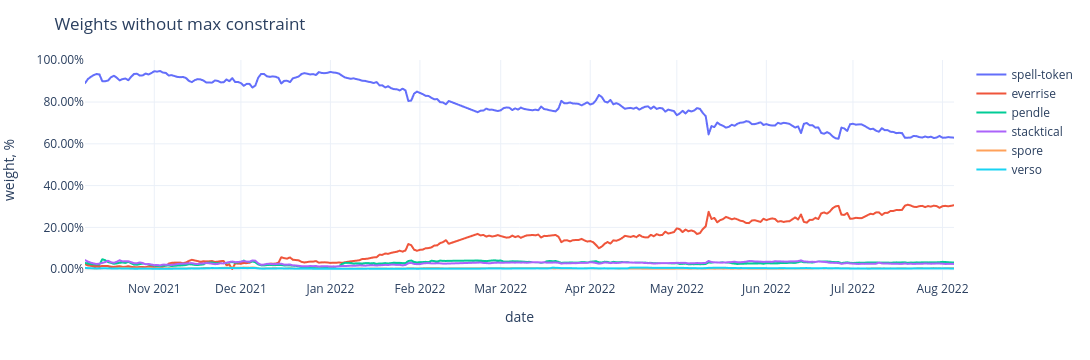

In [71]:
fig = px.line(weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    ## showlegend=False,
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights without max constraint'
)

### Adjust weights

This process adjusts weights to adhere to the weight constraints described in our methodology. In addition the `remove_tiny_weights` function checks for any assets with a weight below the minimum threshold of $0.5\%$ and proportionally increases all remaining weights (which are $> 0.5\%$). Note that after this procedure readjusting weights to respect maximum may be needed.

In [72]:
def adjust_weights(weights, max_weight):
    w = weights.copy()
    
    while (w > max_weight).any(axis=None):
        w[w > max_weight] = max_weight
        c = 1 - w.sum(axis=1)
        w_less = w[w < max_weight]
        w[(w < max_weight) & (w > 0)] += w_less.div(w_less.sum(axis=1), axis=0).mul(c, axis=0)
    
    return w

In [73]:
def remove_tiny_weights(weights, min_weight):
    w = weights.copy()
    
    w[w < min_weight] = 0
    w = w.div(w.sum(axis=1), axis=0)
    
    return w

In [74]:
adjusted_weights = adjust_weights(weights, max_weight=0.3) 
adjusted_weights = remove_tiny_weights(adjusted_weights, min_weight=0.005)
adjusted_weights = adjust_weights(adjusted_weights, max_weight=0.3)

adjusted_weights = adjusted_weights.sort_values(adjusted_weights.last_valid_index(),ascending=False, axis = 1)
adjusted_weights

,spell-token,everrise,pendle,stacktical,spore,verso
date,,,,,,
2021-10-08,0.3,0.154356,0.188846,0.277942,0.038278,0.040578
2021-10-09,0.3,0.137447,0.207430,0.282274,0.033812,0.039038
2021-10-10,0.3,0.142468,0.208592,0.272825,0.036273,0.039842
2021-10-11,0.3,0.134886,0.230527,0.269731,0.028104,0.036752
2021-10-12,0.3,0.139081,0.234522,0.262071,0.028911,0.035415
...,...,...,...,...,...,...
2022-08-01,0.3,0.300000,0.201434,0.151732,0.025706,0.021128
2022-08-02,0.3,0.300000,0.201978,0.147020,0.030489,0.020513
2022-08-03,0.3,0.300000,0.197288,0.150301,0.030893,0.021517


/home/evgeniy/.local/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



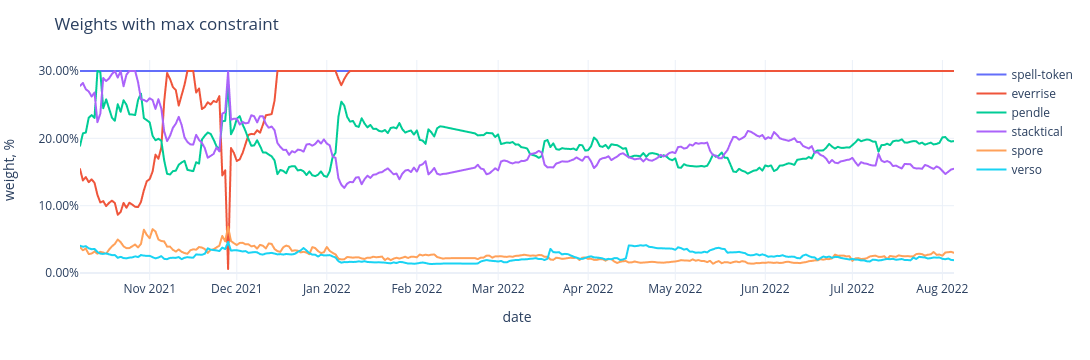

In [75]:
fig = px.line(adjusted_weights,
              labels={'value': 'weight, %', 'variable': ''})
fig.update_traces(
    hovertemplate="%{y}"
)
fig.update_yaxes(
    tickformat=".2%",
)
fig.update_xaxes(
    showspikes=True,
    spikethickness=2,
    spikedash="dot",
    spikecolor="#999999",
    spikemode="across",
)
fig.update_layout(
    hovermode="x",
    hoverdistance=100,  ## Distance to show hover label of data point
    spikedistance=1000,  ## Distance to show spike
    template='plotly_white',
    title='Weights with max constraint'
)

### Convert weights to the [1, 255] scale

On the contract side weights are integer numbers from the interval $[1, 255]$ with total sum $255$, so it's needed to convert retrieved weights to this format.

Note that one can't just round weights to integers after scaling, since it doesn't guarantee that their sum will be $255$. To fix that firstly floor function is applied to the weights and then $1$ is being added to the $k$ weights with largest fractional parts.

In [76]:
def convert_weights(weights):
    w_scaled = weights * 255
    w_res = np.floor(w_scaled).astype(int)    
    remainders = w_scaled - w_res    
    k = round(remainders.sum())
    w_below_max = w_res[w_res<76]
    for i in range(k):
        w_below_max[i] +=1
    for i in w_below_max.index:
        w_res[i] = w_below_max[i]
    return w_res

In [77]:
last_weights = adjusted_weights.iloc[-1].dropna()
last_weights

spell-token    0.300000
everrise       0.300000
pendle         0.195966
stacktical     0.154910
spore          0.030049
verso          0.019075
Name: 2022-08-05 00:00:00, dtype: float64

In [78]:
converted_last_weights = convert_weights(last_weights)
converted_last_weights

spell-token    76
everrise       76
pendle         50
stacktical     40
spore           8
verso           5
Name: 2022-08-05 00:00:00, dtype: int64

## Summary table

In [81]:
cai = pd.DataFrame()
cai.index = chosen_tokens.index
cai['name'] = chosen_tokens['name']
cai['market_cap'] = marketcaps.iloc[-1].astype(int)
cai['price'] = prices_data.iloc[-1]
cai['weight'] = last_weights
cai['weight_converted'] = converted_last_weights
cai['address'] = chosen_tokens['addr']

cai = cai[cai['weight'] > 0]
cai = cai.sort_values("market_cap",ascending=False)
cai

,name,market_cap,price,weight,weight_converted,address
spell-token,Spell,106153912,1.093593e-03,0.300000,76,0xce1bffbd5374dac86a2893119683f4911a2f7814
everrise,EverRise,51586183,7.226235e-04,0.300000,76,0xc17c30e98541188614df99239cabd40280810ca3
pendle,Pendle,5311720,5.504910e-02,0.195966,50,0xfb98b335551a418cd0737375a2ea0ded62ea213b
stacktical,DSLA Protocol,4198881,7.990848e-04,0.154910,40,0xd7c295e399ca928a3a14b01d760e794f1adf8990
spore,Spore,814483,2.376722e-11,0.030049,8,0x6e7f5c0b9f4432716bdd0a77a3601291b9d9e985
verso,Verso,517025,5.508962e-03,0.019075,5,0x846d50248baf8b7ceaa9d9b53bfd12d7d7fbb25a
